In [1]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import astropy
import astropy.units as u

In [2]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [3]:
data=np.sort(rawdat.T, axis=0)
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [4]:
print dm

0      0.166829
1      0.155756
2      0.158467
3      0.156099
4      0.187746
5      0.155636
6      0.199337
7      0.167174
8      0.164981
9      0.170175
10     0.184691
11     0.167333
12     0.175511
13     0.159771
14     0.191312
15     0.162304
16     0.173295
17     0.142913
18     0.148694
19     0.088751
20     0.102439
21     0.107041
22     0.108500
23     0.172548
24     0.181663
25     0.215239
26     0.171187
27     0.160299
28     0.187545
29     0.164269
         ...   
549    0.244100
550    0.200576
551    0.368403
552    0.314697
553    0.235470
554    0.209654
555    0.280114
556    0.275015
557    0.208697
558    0.227617
559    0.954717
560    0.197263
561    0.103415
562    0.120546
563    0.089062
564    0.141254
565    0.200258
566    0.246512
567    0.174239
568    0.447833
569    0.185705
570    0.171796
571    0.478371
572    0.346181
573    0.500545
574    0.171046
575    0.187509
576    0.194014
577    0.560317
578    0.241428
Name: DM_err, Length: 57

In [4]:
from astropy.cosmology import w0waCDM

In [7]:
def w(z):
    for z in range [0.,1.]:
        if z==0:
            wz=w0
        else:
            wz=w0+wa*z/(1+z)
    return wz


In [8]:
def DM(z,H0,Om,Ode,w0,wa):
    cosmo = w0waCDM(H0=H0* u.km / u.s / u.Mpc, Om0=Om,Ode0=Ode,w0=w0,wa=wa)
    DL=cosmo.luminosity_distance(z)
    mag=5*np.log10((DL/(10*u.pc)).decompose())
    return mag

In [9]:
p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0.,2.),('H0',70.0,True,50.,100.),('Ode',0.7,True,0.,2.),('w0',-1.0,True,-2.,2.),('wa',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'],v['Ode'],v['w0'],v['wa'])-mm)/dm

In [10]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [11]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 376
    # data points      = 579
    # variables        = 5
    chi-square         = 561.849604
    reduced chi-square = 0.97883206
    Akaike info crit   = -7.40952991
    Bayesian info crit = 14.3969825
[[Variables]]
    Om:   0.27830785 (init = 0.3)
    H0:   70.0331731 (init = 70)
    Ode:  0.59681547 (init = 0.7)
    w0:  -1.16336826 (init = -1)
    wa:  -0.04395108 (init = -0.1)


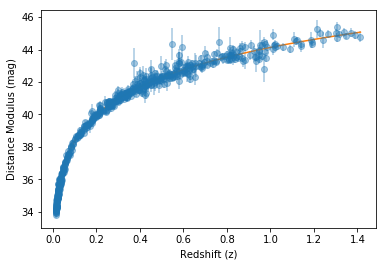

In [14]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOde= mi.params.valuesdict()['Ode']
bestw0 = mi.params.valuesdict()['w0']
bestwa = mi.params.valuesdict()['wa']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm,bestOde,bestw0,bestwa))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [15]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500, thin=1,
                         params=p, is_weighted=True)

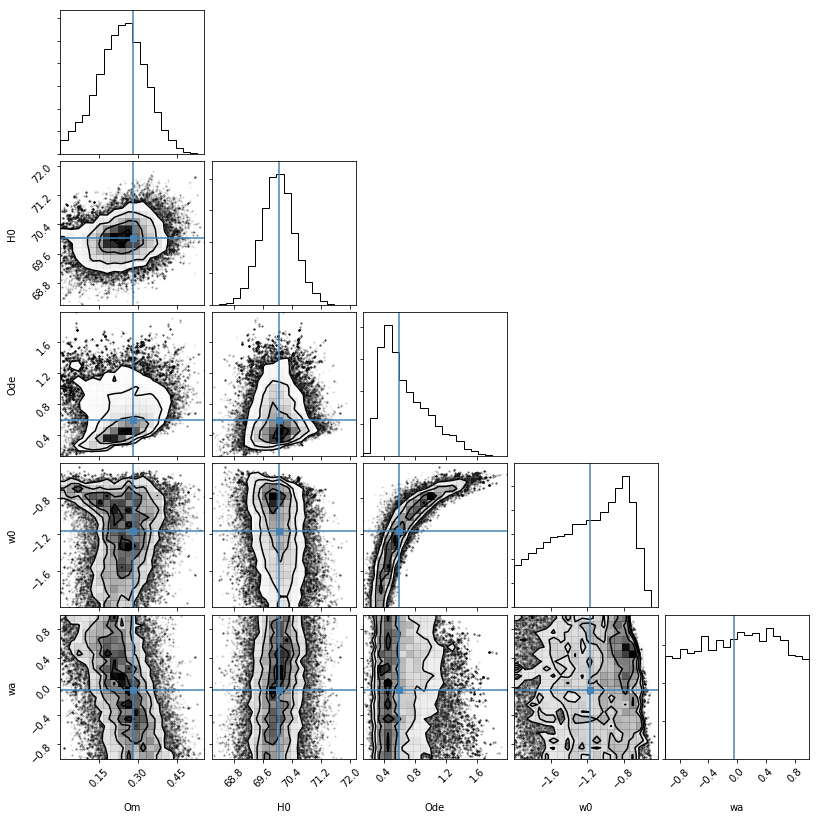

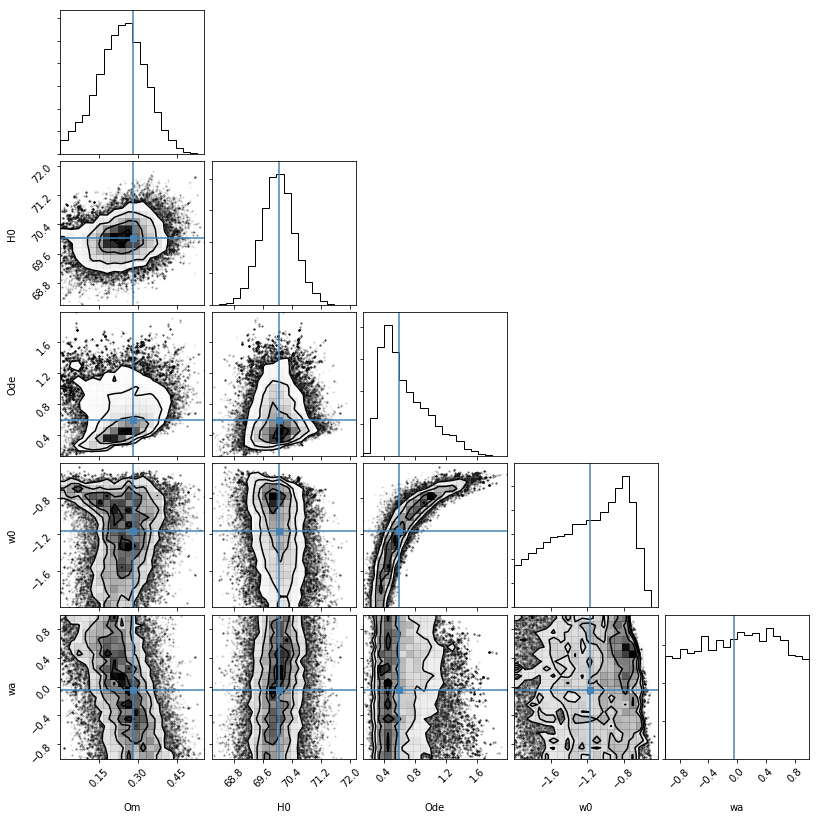

In [16]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))